# Capstone Project - The Battle of Neighborhoods

# Project Title: Neighborhood Recommendation for Opening an Indian Restaurant in Toronto City

### Problem Statement: 

## To recommend a neighborhood for newly opening an Indian Restaurant in Toronto City

This notebook contains only Python code. Separate report can be found in the same repository on Github.

Before starting to import the data and starting its processing, Let's import all the required libraries at the start of the notebook.

If any other packages needed later in the notebook, they will be imported whereever required.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# For scraping the webpage
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# For rendering the map
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

# Matplotlib plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
%matplotlib inline

# Seaborn 
import seaborn as sns


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

### 1. Scraping this [Toronto Data](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) wikipedia page using BeautifulSoup python library

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,'html.parser')

my_table = soup.find('tbody')

Collecting all the HTML data in the form of table

In [3]:
table_data = []

for row in my_table.findAll('tr'):
    row_data = []

    for cell in row.findAll('td'):
        row_data.append(cell.text)

    if(len(row_data) > 0):
        data_item = {
            "Postalcode": row_data[0],
            "Borough": row_data[1],
            "Neighbourhood": row_data[2],
        }
        table_data.append(data_item)

Converting the prepared table into pandas DataFrame -  df

In [4]:
df = pd.DataFrame(table_data)
df.head()

,Borough,Neighbourhood,Postalcode
0,Not assigned,Not assigned\n,M1A
1,Not assigned,Not assigned\n,M2A
2,North York,Parkwoods\n,M3A
3,North York,Victoria Village\n,M4A
4,Downtown Toronto,Harbourfront\n,M5A


In [5]:
df['Neighbourhood'] = df['Neighbourhood'].str.replace('\n','') # removing '\n' from the end of each neighborhood name

In [6]:
# removing the cells where Borough is 'Not assigned'
df_filtered = df.loc[df['Borough'] != 'Not assigned']
df_filtered.head()

,Borough,Neighbourhood,Postalcode
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A
5,North York,Lawrence Heights,M6A
6,North York,Lawrence Manor,M6A


There are still some cells that have a borough but neighborhood is 'Not assigned'. In such cases, substituting the neighborhood name with the borough name.

In [7]:
df_filtered['Neighbourhood'].loc[df_filtered['Neighbourhood']=='Not assigned'] = df_filtered['Borough'].loc[df_filtered['Neighbourhood']=='Not assigned']

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Exploring the number of neighborhoods per borough

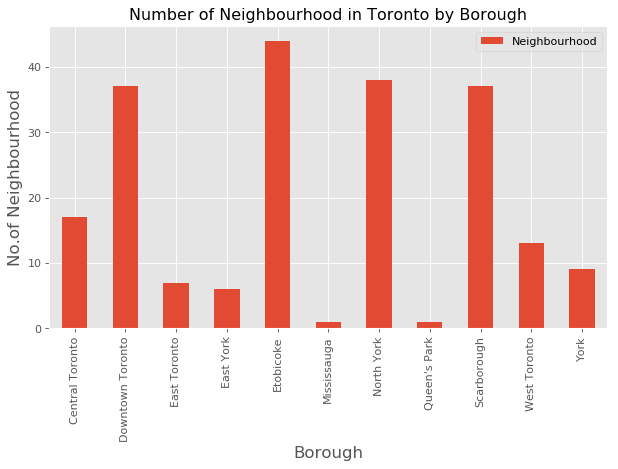

In [21]:
plt.style.use('ggplot')
plt.figure(figsize=(9,5), dpi = 80)
plt.title('Number of Neighbourhood in Toronto by Borough') # adding title
plt.xlabel('Borough', fontsize = 15) # adding label for x-axis
plt.ylabel('No.of Neighbourhood', fontsize=15) # adding label for y-axis
df_filtered.groupby('Borough')['Neighbourhood'].count().plot(kind='bar') # Creating a bar plot
plt.legend() # adding legend

plt.show()

From the above graph, it is clear that the Borough Etobicoke has maximum number of neighborhoods where as Queen's park and Mississauga has lowest number of neighborhoods.

In [8]:
df_filtered.head(30)

,Borough,Neighbourhood,Postalcode
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A
5,North York,Lawrence Heights,M6A
6,North York,Lawrence Manor,M6A
7,Downtown Toronto,Queen's Park,M7A
9,Queen's Park,Queen's Park,M9A
10,Scarborough,Rouge,M1B
11,Scarborough,Malvern,M1B
13,North York,Don Mills North,M3B


In the above dataframe it can be seen than, more than one neighborhood can exist in one postal code area. For example postal code __M1B__, it has 2 neighborhoods Rouge and Malvern. In such cases, using groupby method to group all neighbourhoods in the particular postal code.

This will result in dataframe df_toronto, which we will be using for our entire project here on.

In [9]:
df_toronto = df_filtered.groupby(['Postalcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
df_toronto

,Postalcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [10]:
print('The number of rows in my dataframe = ',df_toronto.shape[0])

The number of rows in my dataframe =  103


### Getting the latitude and the longitude coordinates of each neighborhood

Now, as the dataframe of the postal code of each neighborhood along with the borough name and neighborhood name is built, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

This can be done using [Geocoder](https://geocoder.readthedocs.io/) python package. But, I found it a bit unreliable. first, I had problem with importing it. While importing I got _ModuleNotFoundError_. After trying multiple time, I finally could import it. But then even after making multiple calls, I get _None_ as result.

Hence, the latitude and longitude coordinates for the further analysis were used from the [Geospatial_Data](https://cocl.us/Geospatial_data) dataset which is available in csv file. 



In [15]:
df_locations = pd.read_csv('https://cocl.us/Geospatial_data')
df_locations.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Combining df_torornto and df_locations dataframes into a new dataframe - df_toronto_loc

In [16]:
df_toronto_loc = pd.merge(left=df_toronto ,right=df_locations, left_on='Postalcode', right_on='Postal Code', how='inner')
df_toronto_loc.head()

,Postalcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


As we can see above, there are 2 columns in the resulting dataframe for postal codes. Let's remove the column named 'Postal Code' from the dataframe

In [17]:
df_toronto_loc.drop(['Postal Code'],axis=1,inplace=True)
df_toronto_loc.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [18]:
print('The final dataframe now has %d rows and %d columns' %(df_toronto_loc.shape[0], df_toronto_loc.shape[1]))

The final dataframe now has 103 rows and 5 columns




### 3. Using the Foursquare API to explore the neighborhoods

Starting with credentials

In [22]:
CLIENT_ID = '04CCGGIDEMQYIHJDKAX0HLFUAXENMF45HVQ2MWRWQEGIFDVU' # your Foursquare ID
CLIENT_SECRET = '20FEDXZKERIKFAZDE5NYMIPZRALYUJT5XZY4LNMPT3QEKL0F' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 04CCGGIDEMQYIHJDKAX0HLFUAXENMF45HVQ2MWRWQEGIFDVU
CLIENT_SECRET:20FEDXZKERIKFAZDE5NYMIPZRALYUJT5XZY4LNMPT3QEKL0F


Creating a function to get different category types

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Creating a function to get 100 venues in the area within 1000 meter radius

In [24]:
def get_venues(lat,lng):
    radius=1000
    LIMIT=100
  
    #url to get the data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df   

Creating a function for getting details each venue such as count , rating , tip counts for a given venue id

In [25]:
def get_venue_details(venue_id):
  
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [33]:
toronto_data = pd.merge(left=df_filtered ,right=df_locations, left_on='Postalcode', right_on='Postal Code', how='inner')
toronto_data.head()

,Borough,Neighbourhood,Postalcode,Postal Code,Latitude,Longitude
0,North York,Parkwoods,M3A,M3A,43.753259,-79.329656
1,North York,Victoria Village,M4A,M4A,43.725882,-79.315572
2,Downtown Toronto,Harbourfront,M5A,M5A,43.654260,-79.360636
3,North York,Lawrence Heights,M6A,M6A,43.718518,-79.464763
4,North York,Lawrence Manor,M6A,M6A,43.718518,-79.464763


dropping the columns for 'Postalcode' and 'Postal Code from the dataframe.

In [34]:
toronto_data.drop(['Postalcode', 'Postal Code'],axis=1,inplace=True)
toronto_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,North York,Lawrence Heights,43.718518,-79.464763
4,North York,Lawrence Manor,43.718518,-79.464763


In [35]:
toronto_data.columns=['Borough','Neighborhood','Latitude','Longitude'] # changing the column names
toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,North York,Lawrence Heights,43.718518,-79.464763
4,North York,Lawrence Manor,43.718518,-79.464763


#### 3.1. Creating a neighborhood list that has Indian Restaurants

In [36]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
df_indian_rest=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(toronto_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        df_indian_rest = df_indian_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 210 ) Indian Resturants in Parkwoods, North York:0
( 2 / 210 ) Indian Resturants in Victoria Village, North York:0
( 3 / 210 ) Indian Resturants in Harbourfront, Downtown Toronto:2
( 4 / 210 ) Indian Resturants in Lawrence Heights, North York:0
( 5 / 210 ) Indian Resturants in Lawrence Manor, North York:0
( 6 / 210 ) Indian Resturants in Queen's Park, Downtown Toronto:1
( 7 / 210 ) Indian Resturants in Queen's Park, Queen's Park:0
( 8 / 210 ) Indian Resturants in Rouge, Scarborough:0
( 9 / 210 ) Indian Resturants in Malvern, Scarborough:0
( 10 / 210 ) Indian Resturants in Don Mills North, North York:0
( 11 / 210 ) Indian Resturants in Woodbine Gardens, East York:0
( 12 / 210 ) Indian Resturants in Parkview Hill, East York:0
( 13 / 210 ) Indian Resturants in Ryerson, Downtown Toronto:0
( 14 / 210 ) Indian Resturants in Garden District, Downtown Toronto:0
( 15 / 210 ) Indian Resturants in Glencairn, North York:0
( 16 / 210 ) Indian Resturants in Cloverdale, Etobicoke:0
( 17 / 210 )

In [37]:
df_indian_rest.head()

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,Harbourfront,4af9a379f964a520c91222e3,Bombay Palace
1,Downtown Toronto,Harbourfront,52af6dc5498e33995b0bbf03,Sultan Of Samosas
2,Downtown Toronto,Queen's Park,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine
3,Downtown Toronto,St. James Town,4af9a379f964a520c91222e3,Bombay Palace
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro


In [38]:
df_indian_rest.shape

(81, 4)

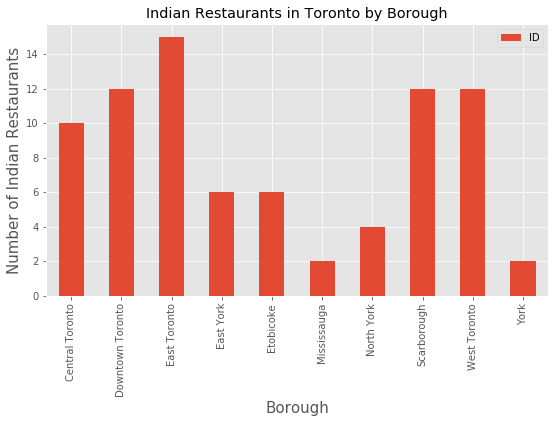

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(9,5))
plt.title('Indian Restaurants in Toronto by Borough') # adding the title to the plot
plt.xlabel('Borough', fontsize = 15) # adding the label for the x-axis
plt.ylabel('Number of Indian Restaurants', fontsize=15) # adding the label for the y-axis
df_indian_rest.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()

plt.show()

Above graph shows that East Toronto has more than 14 Indian restaurants which is highest amongst all the boroughs

In [40]:
east_toronto_indian_rest=df_indian_rest[df_indian_rest['Borough']=='East Toronto']
east_toronto_indian_rest

,Borough,Neighborhood,ID,Name
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
16,East Toronto,The Danforth West,4c1d5337eac020a1cb1048c2,Sher-E-Punjab
17,East Toronto,Riverdale,4c1d5337eac020a1cb1048c2,Sher-E-Punjab
24,East Toronto,The Beaches West,4ae0c7a8f964a520638221e3,Udupi Palace
25,East Toronto,The Beaches West,4afc9816f964a520312422e3,Motimahal
26,East Toronto,The Beaches West,4bac30a2f964a52018ea3ae3,Bombay Chowpatty
27,East Toronto,The Beaches West,4ad9052cf964a520301721e3,Regency Restaurant
28,East Toronto,The Beaches West,4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
29,East Toronto,The Beaches West,4d8d278a1d06b1f712942a3b,Gautama
30,East Toronto,India Bazaar,4ae0c7a8f964a520638221e3,Udupi Palace


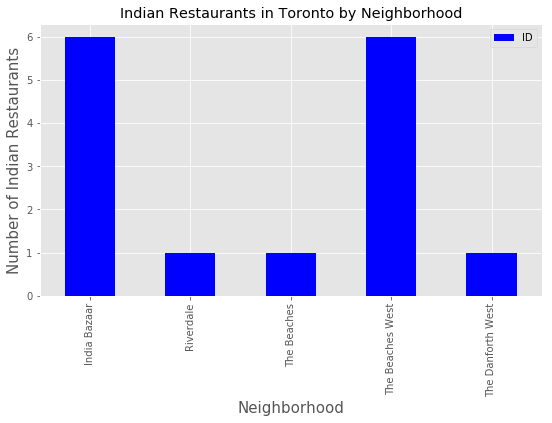

In [43]:
# visualising Indian restaurants in toronto by neighborhood in East Toronto borough
plt.style.use('ggplot')
plt.figure(figsize=(9,5))
plt.title('Indian Restaurants in Toronto by Neighborhood') # adding the title to the plot
plt.xlabel('Neighborhood', fontsize = 15) # adding the label for the x-axis
plt.ylabel('Number of Indian Restaurants', fontsize=15) # adding the label for the y-axis
east_toronto_indian_rest.groupby('Neighborhood')['ID'].count().plot(kind='bar', color='blue')
plt.legend()

plt.show()

The neighborhood _India Bazaar_ and _The Beaches West_ in the borough East Toronto has maximum number of indian restaurants

#### 3.2 Creating the list of Indian restaurants with their details such as name, tips, ratings and likes

In [44]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
details_indian_rest=pd.DataFrame(columns=column_names)
count=1


for row in df_indian_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row


column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
details_indian_rest=pd.DataFrame(columns=column_names)
count=1


for row in df_indian_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5 # assuming the information likes, ratings and tips for such restaurants as 0
    print('(',count,'/',len(df_indian_rest),')','processed')
    details_indian_rest = details_indian_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4af9a379f964a520c91222e3  Bombay Palace     14     7.6    13
( 1 / 81 ) processed
                         ID               Name  Likes  Rating  Tips
0  52af6dc5498e33995b0bbf03  Sultan Of Samosas      9     6.6     4
( 2 / 81 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4bedf8b5e24d20a17b567214  Kothur Indian Cuisine     16     7.9    18
( 3 / 81 ) processed
                         ID           Name  Likes  Rating  Tips
0  4af9a379f964a520c91222e3  Bombay Palace     14     7.6    13
( 4 / 81 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      6     6.8     3
( 5 / 81 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c632edeedd320a19ad5ae29
( 6 / 81 ) processed
                         ID                   Name  Likes  Rating  Tips
0  504bcf32e4b0ef19b0e

In [45]:
details_indian_rest.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Harbourfront,4af9a379f964a520c91222e3,Bombay Palace,14,7.6,13
1,Downtown Toronto,Harbourfront,52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,6.6,4
2,Downtown Toronto,Queen's Park,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,7.9,18
3,Downtown Toronto,St. James Town,4af9a379f964a520c91222e3,Bombay Palace,14,7.6,13
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.8,3


In [46]:
details_indian_rest.shape

(81, 7)

So, finally we have detailed data of 81 Indian Restaurants in Toronto

In [48]:
details_indian_rest.to_csv('Indian Restaurants in Toronto Details.csv', index=False) # Preparing the csv file of this detailed data of indian restaurants

Importing the created csv file in last step, assigning it to new dataframe to check if it is created correctly. This can be made available for public use.

In [49]:
details_indian_rest_from_csv=pd.read_csv('Indian Restaurants in Toronto Details.csv')
details_indian_rest_from_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Harbourfront,4af9a379f964a520c91222e3,Bombay Palace,14,7.6,13
1,Downtown Toronto,Harbourfront,52af6dc5498e33995b0bbf03,Sultan Of Samosas,9,6.6,4
2,Downtown Toronto,Queen's Park,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,7.9,18
3,Downtown Toronto,St. James Town,4af9a379f964a520c91222e3,Bombay Palace,14,7.6,13
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.8,3


In [50]:
details_indian_rest_from_csv.shape

(81, 7)

Everything looks correct. Going Ahead !!

In [52]:
details_indian_rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 7 columns):
Borough         81 non-null object
Neighborhood    81 non-null object
ID              81 non-null object
Name            81 non-null object
Likes           81 non-null object
Rating          81 non-null float64
Tips            81 non-null object
dtypes: float64(1), object(6)
memory usage: 4.5+ KB


We already assigned 0 for likes, tips and ratings of of the restaurants for which no details where available in Foursquare API. Thats why we don't have any missing data in this dataframe.

In [53]:
# changing data types of likes to float64
details_indian_rest['Likes']=details_indian_rest['Likes'].astype('float64') 
details_indian_rest['Tips']=details_indian_rest['Tips'].astype('float64')
details_indian_rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 7 columns):
Borough         81 non-null object
Neighborhood    81 non-null object
ID              81 non-null object
Name            81 non-null object
Likes           81 non-null float64
Rating          81 non-null float64
Tips            81 non-null float64
dtypes: float64(3), object(4)
memory usage: 4.5+ KB


In [57]:
most_liked_indian_rest=details_indian_rest.iloc[details_indian_rest['Likes'].idxmax()] # Restaurants with maximum Likes
print("The restaurant with the Maximum likes is = ", most_liked_indian_rest['Name'], "With maximum of %d Likes" %(most_liked_indian_rest['Likes']))

The restaurant with the Maximum likes is =  Banjara Indian Cuisine With maximum of 142 Likes


In [59]:
high_rated_indian_rest=details_indian_rest.iloc[details_indian_rest['Rating'].idxmax()] # Restaurants with maximum Rating
print("The restaurant with the Maximum Ratings is  ", high_rated_indian_rest['Name'], "With maximum of %f Rating" %(high_rated_indian_rest['Rating']))

The restaurant with the Maximum Ratings is   Banjara Indian Cuisine With maximum of 8.700000 Rating


### 4. Sorting the Neighborhoods, Borough and Ratings of Indian Restaurants in it

In [62]:
details_neighborhood=details_indian_rest.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
details_neighborhood.columns=['Neighborhood','Average Rating']
details_neighborhood.head()

,Neighborhood,Average Rating
0,Agincourt,0.0
1,Bedford Park,7.6
2,Brockton,8.1
3,Cabbagetown,0.0
4,Canada Post Gateway Processing Centre,0.0


In [63]:
details_neighborhood.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
7,Christie,8.4
29,Parkdale Village,8.1
2,Brockton,8.1
13,Exhibition Place,8.1
30,Queen's Park,7.9
20,Lawrence Manor East,7.6
1,Bedford Park,7.6
5,Cedarbrae,7.2
15,Harbourfront,7.1
10,Davisville North,7.1


In [65]:
details_boroughs=details_indian_rest.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
details_boroughs.columns=['Borough','Average Rating']
details_boroughs.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Rating
2,East Toronto,6.973333
6,North York,6.800000
9,York,6.000000
8,West Toronto,4.725000
7,Scarborough,4.675000
3,East York,4.550000
1,Downtown Toronto,3.875000
0,Central Toronto,0.710000
4,Etobicoke,0.000000
5,Mississauga,0.000000


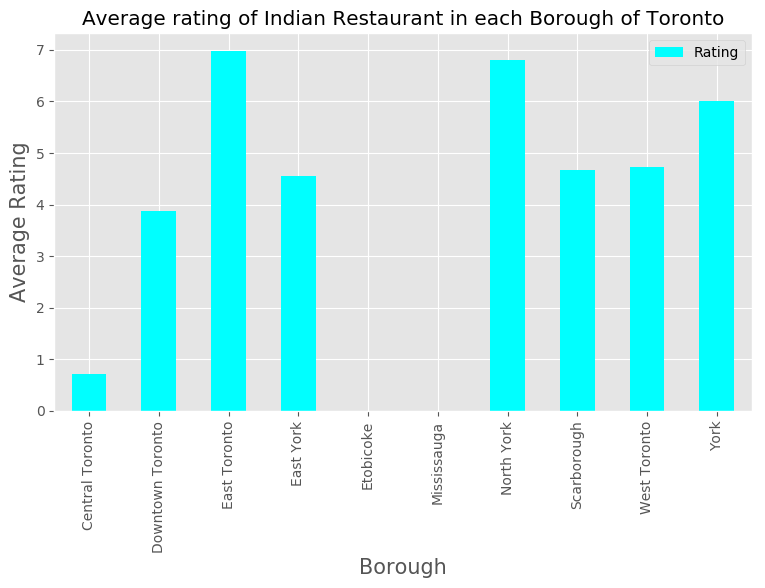

In [66]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurant in each Borough of Toronto')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
details_indian_rest.groupby('Borough').mean()['Rating'].plot(kind='bar',color='cyan')
plt.legend()

plt.show()

The borough __East Toronto__ has maximum average rating of Indian restaurants and it is the same Borough which has maximum number of Indian restaurants

### 5. Visualization on Map of Toronto

Considering all the restaurants with Average Rating more than 7.0 as good restaurants. Visualizing the neighborhoods of only these restaurants on the Map.

In [68]:
details_neighborhood_highrate=details_neighborhood[details_neighborhood['Average Rating']>=7.0] 
details_neighborhood_highrate

,Neighborhood,Average Rating
1,Bedford Park,7.6
2,Brockton,8.1
5,Cedarbrae,7.2
7,Christie,8.4
10,Davisville North,7.1
13,Exhibition Place,8.1
15,Harbourfront,7.1
20,Lawrence Manor East,7.6
29,Parkdale Village,8.1
30,Queen's Park,7.9


In [69]:
print("So Visualizing only %d Neighborhoods on the Map" %(details_neighborhood_highrate.shape[0]))

So Visualizing only 12 Neighborhoods on the Map


In [70]:
details_neighborhood_highrate=pd.merge(details_neighborhood_highrate,toronto_data, on='Neighborhood')
details_neighborhood_highrate

,Neighborhood,Average Rating,Borough,Latitude,Longitude
0,Bedford Park,7.6,North York,43.733283,-79.419750
1,Brockton,8.1,West Toronto,43.636847,-79.428191
2,Cedarbrae,7.2,Scarborough,43.773136,-79.239476
3,Christie,8.4,Downtown Toronto,43.669542,-79.422564
4,Davisville North,7.1,Central Toronto,43.712751,-79.390197
5,Exhibition Place,8.1,West Toronto,43.636847,-79.428191
6,Harbourfront,7.1,Downtown Toronto,43.654260,-79.360636
7,Lawrence Manor East,7.6,North York,43.733283,-79.419750
8,Parkdale Village,8.1,West Toronto,43.636847,-79.428191
9,Queen's Park,7.9,Downtown Toronto,43.662301,-79.389494


Rearranging the column sequence in the dataframe

In [71]:
details_neighborhood_highrate=details_neighborhood_highrate[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
details_neighborhood_highrate

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,North York,Bedford Park,43.733283,-79.419750,7.6
1,West Toronto,Brockton,43.636847,-79.428191,8.1
2,Scarborough,Cedarbrae,43.773136,-79.239476,7.2
3,Downtown Toronto,Christie,43.669542,-79.422564,8.4
4,Central Toronto,Davisville North,43.712751,-79.390197,7.1
5,West Toronto,Exhibition Place,43.636847,-79.428191,8.1
6,Downtown Toronto,Harbourfront,43.654260,-79.360636,7.1
7,North York,Lawrence Manor East,43.733283,-79.419750,7.6
8,West Toronto,Parkdale Village,43.636847,-79.428191,8.1
9,Downtown Toronto,Queen's Park,43.662301,-79.389494,7.9


In [72]:
details_neighborhood_highrate.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
3,Downtown Toronto,Christie,43.669542,-79.422564,8.4
1,West Toronto,Brockton,43.636847,-79.428191,8.1
5,West Toronto,Exhibition Place,43.636847,-79.428191,8.1
8,West Toronto,Parkdale Village,43.636847,-79.428191,8.1
9,Downtown Toronto,Queen's Park,43.662301,-79.389494,7.9
10,Queen's Park,Queen's Park,43.667856,-79.532242,7.9
0,North York,Bedford Park,43.733283,-79.419750,7.6
7,North York,Lawrence Manor East,43.733283,-79.419750,7.6
2,Scarborough,Cedarbrae,43.773136,-79.239476,7.2
4,Central Toronto,Davisville North,43.712751,-79.390197,7.1


In [73]:
# Getting Location coordinates of Toronto
address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [74]:
# creating map
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [79]:
# add markers to the map

for lat, lon, neigh, avgrate in zip(details_neighborhood_highrate['Latitude'], details_neighborhood_highrate['Longitude'], details_neighborhood_highrate['Neighborhood'], details_neighborhood_highrate['Average Rating']):
    label = folium.Popup(str(neigh) + ' Rating ' + str(avgrate), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(toronto_map)
# Visualize the Map
toronto_map       

#### Findings

1. Christie in Downtown toronto is the one of the best neighborhood for Indian food
2. The East Toronto borough has maximum number of Indian restaurants and 80% of these restaurants are situated in its India Bazaar and The Beaches West neighborhood
3. York, Mississauga, North York and Etobicoke boroughs are having lower number of Indian Restaurants such as 2,2,4 and 6 Indian restaurants respectively.
4. In terms of average ratings of Indian Restaurants, East Toronto borough tops the chart followed by North York, York, West Toronto and Downtown Toronto

#### Neighborhood Recommendations

1. West Toronto borough has 2nd highest number of Indian Restaurants in Toronto but has poor average rating for these restaurants. This can be good opportunities for investors to open a restaurant in West Toronto to provide high quality service and food which would result in increased customer flow and profit. The neighborhoods Brockton, Exhibition Place and Parkdale Village has 8.1 average rating for Indian restaurants. Hence, opening new Indian restaurant in this place can lead to high competition. 

Hence, Recommended Neighborhoods in West Toronto --> All except Brockton, Exhibition Place and Parkdale Village.

2. North York borough has 2nd highest average rating for Indian Restaurants but has only 4 restaurants for this category. Hence, this can be one of the recommended boroughs to start Indian restaurants.

Hence, Recommended Neighborhoods in North York --> All

3. As per analysis in this notebook, the borough York has 3rd highest average rating for Indian Restaurants but it has only 2 Indian Restaurants. This borough can be the best place to start new Indian restaurant as it will face less competition from other restaurants of same category and need to provide good quality of service and food to get best rating.

Hence, Recommended Neighborhoods in York --> All

##### The more robust neighborhood recommendations can be made by analysing the Indian Populations in these boroughs in Toronto

### This is the end of this analysis
# Thank You for your time.